### Time Series Forecasting

In this effort, we will be using a Kaggle dataset to investigate trends in order demands for specific meal types. We will leverage recurrent neural networks in an attempt to forecast future demand and evaluate model performance/predictions.

### Code

In [66]:
import warnings
warnings.filterwarnings('ignore')

# Import libraries that we will need later
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

Based on the CSV files downloaded from the Kaggle site, it looks like the data has already been split into a training and testing set. Let's load in the training set and inspect the contents of this meal data.

In [7]:
# Load in training data and inspect
df = pd.read_csv('meal_data/train.csv')
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456548 entries, 0 to 456547
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     456548 non-null  int64  
 1   week                   456548 non-null  int64  
 2   center_id              456548 non-null  int64  
 3   meal_id                456548 non-null  int64  
 4   checkout_price         456548 non-null  float64
 5   base_price             456548 non-null  float64
 6   emailer_for_promotion  456548 non-null  int64  
 7   homepage_featured      456548 non-null  int64  
 8   num_orders             456548 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 31.3 MB
None
        id  week  center_id  meal_id  checkout_price  base_price  \
0  1379560     1         55     1885          136.83      152.29   
1  1466964     1         55     1993          136.83      135.83   
2  1346989     1         55     2539          1

The meal data training set consists of 456,548 entries and 9 variables, which are:
- `id`: integer representing unique identifier for entry in table (don't think this will have much predictive power in our model)
- `week`: integer representing time interval (training data is from 1 to 145 weeks)
- `center_id`: integer representing ID of fulfillment center 
- `checkout_price`: float representing checkout price 
- `base_price`: float representing base price
- `emailer_for_promotion`: binary flag representing if there is an email to contact for promotion
- `homepage_featured`: binary flag representing if homepage is featured 
- `num_orders`: integer representing number of orders in entry (*TARGET VARIABLE*)

Since the number of orders (`num_orders`) is the variable we will be trying to predict in this problem scenario, let's quickly check out the distribution to see if we can gain any insight about meal demand. 

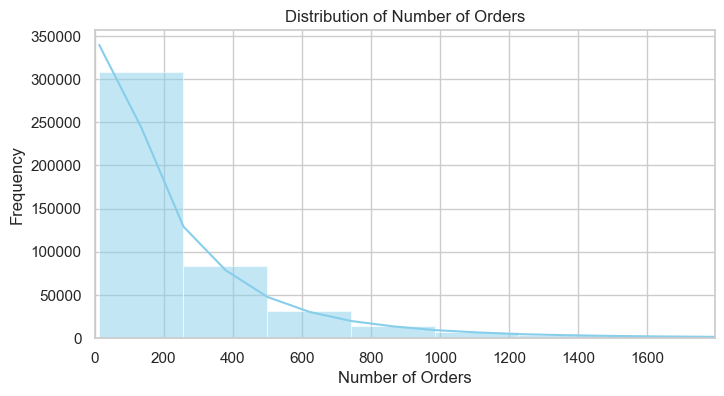

In [18]:
# Histogram for number of orders
sns.set(style="whitegrid")
plt.figure(figsize=(8, 4))
sns.histplot(df['num_orders'], bins=100, kde=True, color='skyblue')
plt.title('Distribution of Number of Orders')
plt.xlabel('Number of Orders')
plt.ylabel('Frequency')
plt.xlim(0, df['num_orders'].quantile(0.99))
plt.show()

This data does not appear to be normally distributed, as most of the orders towards to the lower end from 0 to 400. The overwhelming majority of entries contain 200 or less orders. Now that we have our data in and completed an initial inspection, let's check for any missing values before getting into model building. 

In [21]:
# Check for missing values
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

Series([], dtype: int64)


There are no missing values here, as this dataset is pretty clean - false alarm. Now, let's select 10 unique meals by using the `meal_id` variable.

In [25]:
# Grab 10 random meal IDs
unique_meals = df['meal_id'].unique()
np.random.seed(42)
selected_meals = np.random.choice(unique_meals, size=10, replace=False)
print("Selected Meal IDs:", selected_meals)

Selected Meal IDs: [2492 2494 2569 2290 1558 2704 2126 2304 2139 1525]


The randomly selected meals from the training set we will be trying to forecast correspond with the IDs outputted above (not gonna list them). Let's visualize the demand of these meals over time.

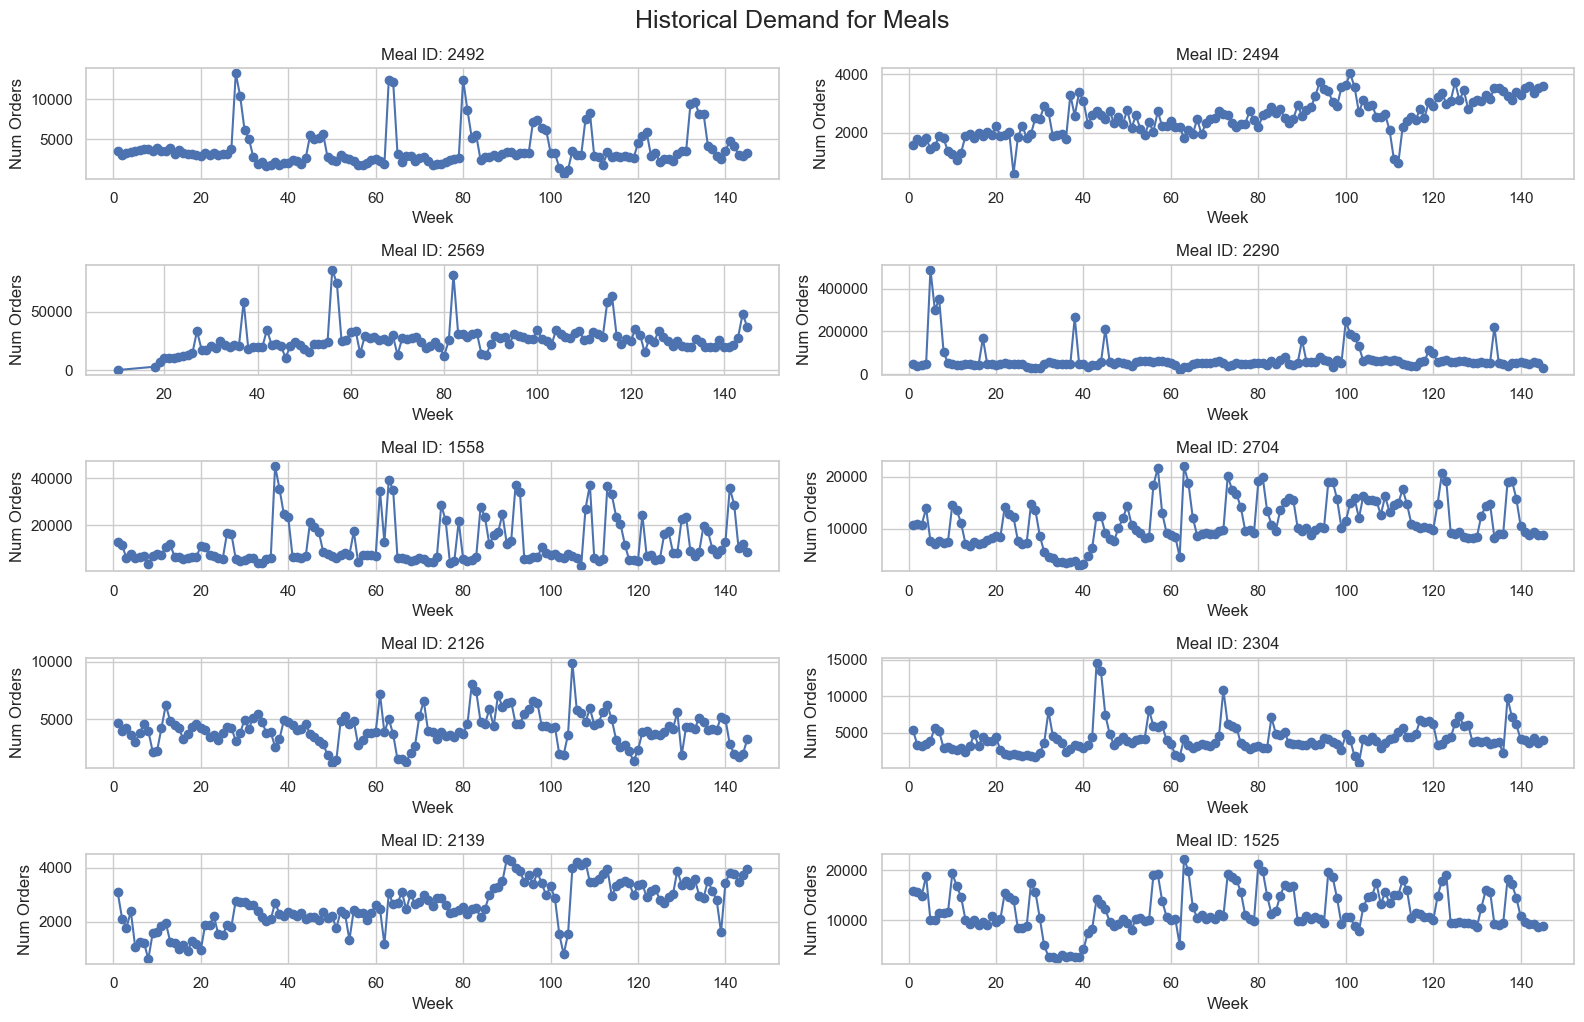

In [38]:
# Plot number of orders for each meal over time
plt.figure(figsize=(16, 10))
for i, meal in enumerate(selected_meals):
    plt.subplot(5, 2, i + 1)
    meal_df = df[df['meal_id'] == meal].groupby('week')['num_orders'].sum()
    plt.plot(meal_df.index, meal_df.values, marker='o')
    plt.title(f"Meal ID: {meal}")
    plt.xlabel("Week")
    plt.ylabel("Num Orders")
    plt.tight_layout()
plt.suptitle("Historical Demand for Meals", fontsize=18, y=1.02)
plt.show()

For each of our randomly selected meals, we can analyze how the demand changes from week to week. The scales along the y-axis for each plot are different, so it may be difficult to generalize deltas from one meal to the next. However, we can observe trends for each meal in their own "vacuum". Meal 2139 had a steady increase in demand until week 100, where we can see a sharp drop in the number of orders. What could have caused this? If we look at Meal 2290, the demand appears to be pretty consistent from week to week, except around week 7 or 8. There is a HUGE spike where this meal was ordered over 400,000 times. Could Meal 2290 represent a turkey and mashed potato dinner that experiences a surge in demand around Thanksgiving? Let's move onto some preprocessing before building our RNN.

In [43]:
# Helper function to prepare data for RNN
def prepare_sequences(series, sequence_length=10):
    scaler = MinMaxScaler()
    scaled_series = scaler.fit_transform(series.values.reshape(-1, 1))
    X, y = [], []
    for i in range(len(scaled_series) - sequence_length):
        X.append(scaled_series[i:i+sequence_length])
        y.append(scaled_series[i+sequence_length])
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)
    return X, y, scaler

We have our helper function implemented, so let's try it on one of our 10 randomly selected meals to confirm it is functioning properly.

In [50]:
# Try out helper function first meal
meal_id = selected_meals[0]
meal_df = df[df['meal_id'] == meal_id].groupby('week')['num_orders'].sum().reset_index()
all_weeks = pd.DataFrame({'week': range(df['week'].min(), df['week'].max() + 1)})
meal_df = pd.merge(all_weeks, meal_df, on='week', how='left').fillna(method='ffill')
X, y, scaler = prepare_sequences(meal_df['num_orders'])
print("X shape:", X.shape)
print("y shape:", y.shape)  

X shape: torch.Size([135, 10, 1])
y shape: torch.Size([135, 1])


It looks like the data got transformed into the correct shape as needed by Pytorch. Let's build our initial RNN and train it. 

In [56]:
# Define class/functions for RNN
class SimpleRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=1, output_size=1):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x) 
        out = out[:, -1, :]   
        out = self.fc(out)    
        return out

## Meal 2492

In [68]:
# Initialize model and set up training loop (starting with 10 epochs)
model = SimpleRNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs = 10
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        y_true = y.numpy()
        y_pred = outputs.numpy()
        mae = mean_absolute_error(y_true, y_pred)
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")

Epoch [1/10], Loss: 0.160171, MAE: 0.3438, RMSE: 0.4002
Epoch [2/10], Loss: 0.049863, MAE: 0.1293, RMSE: 0.2233
Epoch [3/10], Loss: 0.072033, MAE: 0.2488, RMSE: 0.2684
Epoch [4/10], Loss: 0.054741, MAE: 0.2107, RMSE: 0.2340
Epoch [5/10], Loss: 0.038013, MAE: 0.1452, RMSE: 0.1950
Epoch [6/10], Loss: 0.040214, MAE: 0.1140, RMSE: 0.2005
Epoch [7/10], Loss: 0.044454, MAE: 0.1186, RMSE: 0.2108
Epoch [8/10], Loss: 0.043247, MAE: 0.1164, RMSE: 0.2080
Epoch [9/10], Loss: 0.038668, MAE: 0.1089, RMSE: 0.1966
Epoch [10/10], Loss: 0.034349, MAE: 0.1096, RMSE: 0.1853


We can see that as the RNN loops over the dataset, it is achieving less error with each iteration. The final epoch yielded a mean average error (MAE) of only 0.1096. Let's generate a forecast for this first meal (Meal 2492) and visualize the RNN's predictions. 

In [71]:
# Generate predictions (forecast) for first meal
model.eval()
input_seq = X[-1].unsqueeze(0) 
predictions = []
with torch.no_grad():
    for _ in range(10):
        pred = model(input_seq)
        predictions.append(pred.item())
        input_seq = torch.cat((input_seq[:, 1:, :], pred.view(1, 1, 1)), dim=1)

forecast = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
historical = meal_df['num_orders'].values
weeks = meal_df['week'].values
future_weeks = np.arange(weeks[-1] + 1, weeks[-1] + 11)

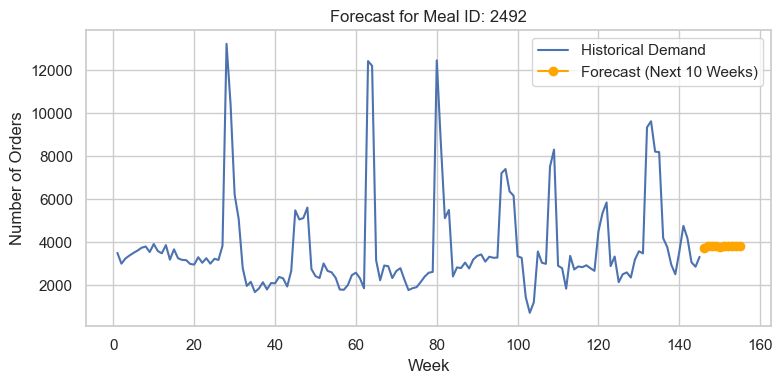

In [75]:
# Plot historical demand vs forecasted demand
plt.figure(figsize=(8, 4))
plt.plot(weeks, historical, label='Historical Demand')
plt.plot(future_weeks, forecast, label='Forecast (Next 10 Weeks)', color='orange', marker='o')
plt.title(f'Forecast for Meal ID: {meal_id}')
plt.xlabel('Week')
plt.ylabel('Number of Orders')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

We can see that for Meal 2492, the RNN is predicting a pretty steady trend of about 3900 meals being demanded over each the next 10 weeks. This may be one of the more difficult meals to accurately forecast due to its volatility. It seems like there is a spike in demand every 15 weeks or so. Now that we know our code and process works, I want meal data to test the RNN against and evaluate its performance. Let's use Meal 2492 as our guinea pig. We will train on weeks 1 through 135 of the training data, test against weeks 136 through 145 to evaluate model performance, then generate predictions on weeks 146 through 155 for submission (like a Kaggle competition). Once we can confirm this code also works, we will loop this same process over all 10 randomly selected meals. 

In [84]:
# Train on weeks 1-135, test on weeks 136-145, and forecast for weeks 146-155
meal_id = selected_meals[0]
meal_df = df[df['meal_id'] == meal_id].groupby('week')['num_orders'].sum().reset_index()
all_weeks = pd.DataFrame({'week': range(1, 146)})
meal_df = pd.merge(all_weeks, meal_df, on='week', how='left').fillna(method='ffill')
train_df = meal_df[meal_df['week'] <= 135]
X, y, scaler = prepare_sequences(train_df['num_orders'], sequence_length=10)
val_actual = meal_df[meal_df['week'] > 135]['num_orders'].values

In [86]:
# Train RNN on Meal 2492 data
model = SimpleRNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs = 10
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        mae = mean_absolute_error(y.numpy(), outputs.numpy())
        rmse = mean_squared_error(y.numpy(), outputs.numpy(), squared=False)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}, MAE: {mae:.2f}, RMSE: {rmse:.2f}")

Epoch [1/10], Loss: 0.204882, MAE: 0.41, RMSE: 0.45
Epoch [2/10], Loss: 0.048109, MAE: 0.12, RMSE: 0.22
Epoch [3/10], Loss: 0.064550, MAE: 0.24, RMSE: 0.25
Epoch [4/10], Loss: 0.058743, MAE: 0.22, RMSE: 0.24
Epoch [5/10], Loss: 0.038915, MAE: 0.16, RMSE: 0.20
Epoch [6/10], Loss: 0.034935, MAE: 0.12, RMSE: 0.19
Epoch [7/10], Loss: 0.038366, MAE: 0.11, RMSE: 0.20
Epoch [8/10], Loss: 0.040752, MAE: 0.11, RMSE: 0.20
Epoch [9/10], Loss: 0.039752, MAE: 0.11, RMSE: 0.20
Epoch [10/10], Loss: 0.036537, MAE: 0.11, RMSE: 0.19


Obviously, this is the same output as a couple of cells up the notebook. Let's see how the model's predictions for weeks 136-145 compare against the real historical data. 

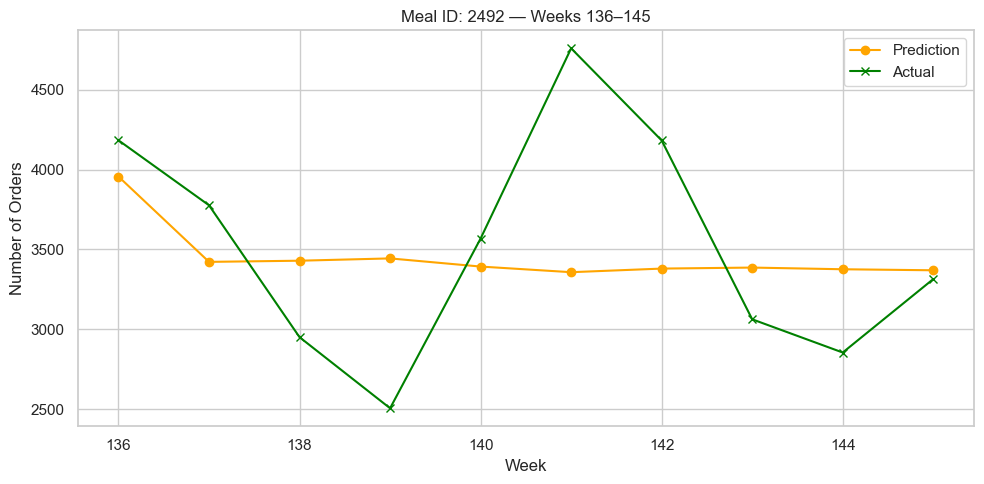

Validation MAE: 527.92, RMSE: 656.28
Predictions for Weeks 146–155: [3389.00132871 3377.69090438 3360.161129   3370.28013682 3379.60337257
 3374.81566405 3371.37366962 3372.79036808 3374.20519853 3374.04903293]


In [93]:
# Generate predictions and see how accurate compared to historical data, then forecast future demand
model.eval()
input_seq = X[-1].unsqueeze(0)  
val_predictions = []
with torch.no_grad():
    for _ in range(10):  
        pred = model(input_seq)
        val_predictions.append(pred.item())
        input_seq = torch.cat((input_seq[:, 1:, :], pred.view(1, 1, 1)), dim=1)
val_forecast = scaler.inverse_transform(np.array(val_predictions).reshape(-1, 1)).flatten()

weeks = np.arange(136, 146)
plt.figure(figsize=(8, 4))
plt.plot(weeks, val_forecast, label='Prediction', marker='o', color='orange')
plt.plot(weeks, val_actual, label='Actual', marker='x', color='green')
plt.title(f'Meal ID: {meal_id} — Weeks 136–145')
plt.xlabel('Week')
plt.ylabel('Number of Orders')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

mae = mean_absolute_error(val_actual, val_forecast)
rmse = mean_squared_error(val_actual, val_forecast, squared=False)
print(f"Validation MAE: {mae:.2f}, RMSE: {rmse:.2f}")

test_predictions = []
input_seq = torch.tensor(scaler.transform(meal_df['num_orders'].values[-10:].reshape(-1, 1)), dtype=torch.float32).unsqueeze(0)
with torch.no_grad():
    for _ in range(10):
        pred = model(input_seq)
        test_predictions.append(pred.item())
        input_seq = torch.cat((input_seq[:, 1:, :], pred.view(1, 1, 1)), dim=1)
test_forecast = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1)).flatten()
print(f"Predictions for Weeks 146–155: {test_forecast}")

In this plot, the orange line represents the RNN's prediction of the historical data, while the green line represents the actual historical data. We can see that this RNN does not do a great job of predicting the final weeks of demand for Meal 2492, as this achieves an MAE of about 528. This means the average RNN prediction is off by about 528 orders. Also, we can see the RNN's forecast for weeks 146-155, but there is no truth data to compare this against to see how accurate it is. As stated before, this may be one of the harder meals to predict due to how volatile the demand is for it. Let's use this same pipeline for the remaining 9 meals.

## Meal 2494

Epoch [1/10], Loss: 0.396443, MAE: 0.61, RMSE: 0.63
Epoch [2/10], Loss: 0.079961, MAE: 0.25, RMSE: 0.28
Epoch [3/10], Loss: 0.083054, MAE: 0.25, RMSE: 0.29
Epoch [4/10], Loss: 0.072476, MAE: 0.23, RMSE: 0.27
Epoch [5/10], Loss: 0.024350, MAE: 0.12, RMSE: 0.16
Epoch [6/10], Loss: 0.037839, MAE: 0.15, RMSE: 0.19
Epoch [7/10], Loss: 0.050534, MAE: 0.18, RMSE: 0.22
Epoch [8/10], Loss: 0.045192, MAE: 0.17, RMSE: 0.21
Epoch [9/10], Loss: 0.032608, MAE: 0.14, RMSE: 0.18
Epoch [10/10], Loss: 0.023471, MAE: 0.12, RMSE: 0.15


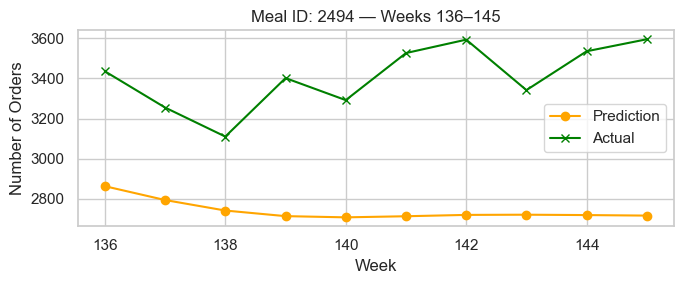

Validation MAE: 668.95, RMSE: 689.71


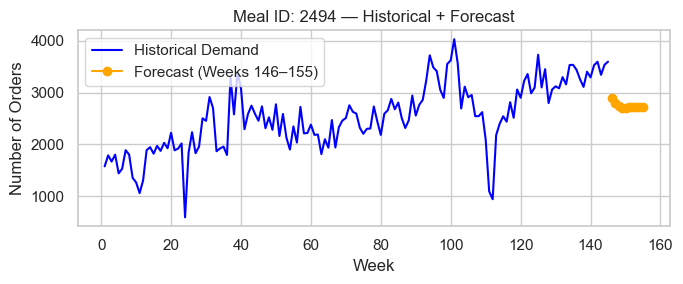

Predictions for Weeks 146–155: [2887.57482469 2802.10574549 2742.337897   2711.78342402 2707.27190173
 2713.95774531 2720.71807158 2721.44591469 2718.13655102 2715.62276059]


In [121]:
# Same pipeline for next meal
meal_id = selected_meals[1]
meal_df = df[df['meal_id'] == meal_id].groupby('week')['num_orders'].sum().reset_index()
all_weeks = pd.DataFrame({'week': range(1, 146)})
meal_df = pd.merge(all_weeks, meal_df, on='week', how='left').fillna(method='ffill')
train_df = meal_df[meal_df['week'] <= 135]
X, y, scaler = prepare_sequences(train_df['num_orders'], sequence_length=10)
val_actual = meal_df[meal_df['week'] > 135]['num_orders'].values

model = SimpleRNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
epochs = 10
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        mae = mean_absolute_error(y.numpy(), outputs.numpy())
        rmse = mean_squared_error(y.numpy(), outputs.numpy(), squared=False)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}, MAE: {mae:.2f}, RMSE: {rmse:.2f}")

model.eval()
input_seq = X[-1].unsqueeze(0)  
val_predictions = []
with torch.no_grad():
    for _ in range(10):  
        pred = model(input_seq)
        val_predictions.append(pred.item())
        input_seq = torch.cat((input_seq[:, 1:, :], pred.view(1, 1, 1)), dim=1)
val_forecast = scaler.inverse_transform(np.array(val_predictions).reshape(-1, 1)).flatten()

weeks = np.arange(136, 146)
plt.figure(figsize=(7, 3))
plt.plot(weeks, val_forecast, label='Prediction', marker='o', color='orange')
plt.plot(weeks, val_actual, label='Actual', marker='x', color='green')
plt.title(f'Meal ID: {meal_id} — Weeks 136–145')
plt.xlabel('Week')
plt.ylabel('Number of Orders')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

mae = mean_absolute_error(val_actual, val_forecast)
rmse = mean_squared_error(val_actual, val_forecast, squared=False)
print(f"Validation MAE: {mae:.2f}, RMSE: {rmse:.2f}")

test_predictions = []
input_seq = torch.tensor(scaler.transform(meal_df['num_orders'].values[-10:].reshape(-1, 1)), dtype=torch.float32).unsqueeze(0)
with torch.no_grad():
    for _ in range(10):
        pred = model(input_seq)
        test_predictions.append(pred.item())
        input_seq = torch.cat((input_seq[:, 1:, :], pred.view(1, 1, 1)), dim=1)
test_forecast = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1)).flatten()
historical_weeks = meal_df['week'].values
historical_orders = meal_df['num_orders'].values
forecast_weeks = np.arange(146, 156)

plt.figure(figsize=(7, 3))
plt.plot(historical_weeks, historical_orders, label='Historical Demand', color='blue')
plt.plot(forecast_weeks, test_forecast, label='Forecast (Weeks 146–155)', marker='o', color='orange')
plt.title(f'Meal ID: {meal_id} — Historical + Forecast')
plt.xlabel('Week')
plt.ylabel('Number of Orders')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

test_predictions = []
input_seq = torch.tensor(scaler.transform(meal_df['num_orders'].values[-10:].reshape(-1, 1)), dtype=torch.float32).unsqueeze(0)
with torch.no_grad():
    for _ in range(10):
        pred = model(input_seq)
        test_predictions.append(pred.item())
        input_seq = torch.cat((input_seq[:, 1:, :], pred.view(1, 1, 1)), dim=1)
test_forecast = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1)).flatten()
print(f"Predictions for Weeks 146–155: {test_forecast}")

This performance is kind of a disappointment for Meal 2494, as the RNN yields an MAE of about 748 orders. This is a pretty large number to be off by considering that the average demand is probably around 2700. Also, I have very little faith in the predictions forecasted from weeks 146-155. I wonder why the RNN did so bad with this one. Maybe it is predicting another sharp drop, like we see around weeks 22 and 112? Let's move onto the next meal. 

## Meal 2290

Epoch [1/10], Loss: 0.065871, MAE: 0.25, RMSE: 0.26
Epoch [2/10], Loss: 0.013684, MAE: 0.08, RMSE: 0.12
Epoch [3/10], Loss: 0.028037, MAE: 0.14, RMSE: 0.17
Epoch [4/10], Loss: 0.019494, MAE: 0.11, RMSE: 0.14
Epoch [5/10], Loss: 0.009526, MAE: 0.05, RMSE: 0.10
Epoch [6/10], Loss: 0.007689, MAE: 0.06, RMSE: 0.09
Epoch [7/10], Loss: 0.012151, MAE: 0.10, RMSE: 0.11
Epoch [8/10], Loss: 0.012997, MAE: 0.11, RMSE: 0.11
Epoch [9/10], Loss: 0.010209, MAE: 0.09, RMSE: 0.10
Epoch [10/10], Loss: 0.007779, MAE: 0.06, RMSE: 0.09


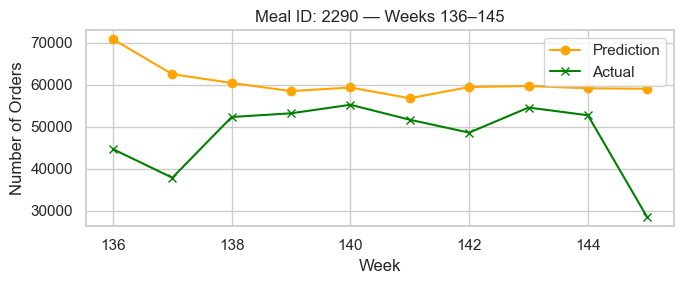

Validation MAE: 12638.45, RMSE: 15965.47


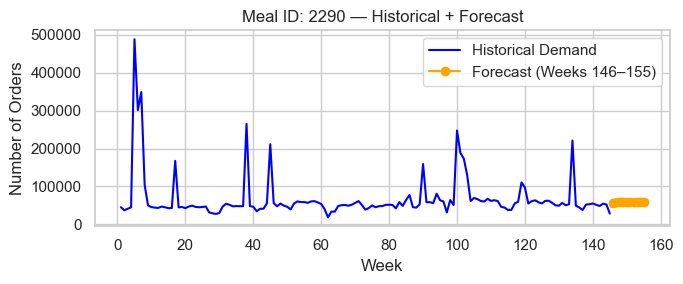

Predictions for Weeks 146–155: [56866.71370366 58581.12818661 59025.87852912 59278.99544919
 59154.03416759 59543.03196159 59056.28614751 59034.72686267
 59137.35563613 59156.60574733]


In [123]:
# Same pipeline for next meal
meal_id = selected_meals[3]
meal_df = df[df['meal_id'] == meal_id].groupby('week')['num_orders'].sum().reset_index()
all_weeks = pd.DataFrame({'week': range(1, 146)})
meal_df = pd.merge(all_weeks, meal_df, on='week', how='left').fillna(method='ffill')
train_df = meal_df[meal_df['week'] <= 135]
X, y, scaler = prepare_sequences(train_df['num_orders'], sequence_length=10)
val_actual = meal_df[meal_df['week'] > 135]['num_orders'].values

model = SimpleRNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
epochs = 10
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        mae = mean_absolute_error(y.numpy(), outputs.numpy())
        rmse = mean_squared_error(y.numpy(), outputs.numpy(), squared=False)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}, MAE: {mae:.2f}, RMSE: {rmse:.2f}")

model.eval()
input_seq = X[-1].unsqueeze(0)  
val_predictions = []
with torch.no_grad():
    for _ in range(10):  
        pred = model(input_seq)
        val_predictions.append(pred.item())
        input_seq = torch.cat((input_seq[:, 1:, :], pred.view(1, 1, 1)), dim=1)
val_forecast = scaler.inverse_transform(np.array(val_predictions).reshape(-1, 1)).flatten()

weeks = np.arange(136, 146)
plt.figure(figsize=(7, 3))
plt.plot(weeks, val_forecast, label='Prediction', marker='o', color='orange')
plt.plot(weeks, val_actual, label='Actual', marker='x', color='green')
plt.title(f'Meal ID: {meal_id} — Weeks 136–145')
plt.xlabel('Week')
plt.ylabel('Number of Orders')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

mae = mean_absolute_error(val_actual, val_forecast)
rmse = mean_squared_error(val_actual, val_forecast, squared=False)
print(f"Validation MAE: {mae:.2f}, RMSE: {rmse:.2f}")

test_predictions = []
input_seq = torch.tensor(scaler.transform(meal_df['num_orders'].values[-10:].reshape(-1, 1)), dtype=torch.float32).unsqueeze(0)
with torch.no_grad():
    for _ in range(10):
        pred = model(input_seq)
        test_predictions.append(pred.item())
        input_seq = torch.cat((input_seq[:, 1:, :], pred.view(1, 1, 1)), dim=1)
test_forecast = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1)).flatten()
historical_weeks = meal_df['week'].values
historical_orders = meal_df['num_orders'].values
forecast_weeks = np.arange(146, 156)

plt.figure(figsize=(7, 3))
plt.plot(historical_weeks, historical_orders, label='Historical Demand', color='blue')
plt.plot(forecast_weeks, test_forecast, label='Forecast (Weeks 146–155)', marker='o', color='orange')
plt.title(f'Meal ID: {meal_id} — Historical + Forecast')
plt.xlabel('Week')
plt.ylabel('Number of Orders')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

test_predictions = []
input_seq = torch.tensor(scaler.transform(meal_df['num_orders'].values[-10:].reshape(-1, 1)), dtype=torch.float32).unsqueeze(0)
with torch.no_grad():
    for _ in range(10):
        pred = model(input_seq)
        test_predictions.append(pred.item())
        input_seq = torch.cat((input_seq[:, 1:, :], pred.view(1, 1, 1)), dim=1)
test_forecast = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1)).flatten()
print(f"Predictions for Weeks 146–155: {test_forecast}")

This model consistently overpredicts the amount of demand for weeks 136-145 and yields an MAE of about 10199. However, it does do a good job of predicting the dip at week 137. For the upcoming weeks, it forecasts a pretty steady demand of about 59000 orders per week (which seems unlikely given the historical trends). Let's move to the next meal. 

## Meal 1558

Epoch [1/10], Loss: 0.051946, MAE: 0.16, RMSE: 0.23
Epoch [2/10], Loss: 0.078453, MAE: 0.26, RMSE: 0.28
Epoch [3/10], Loss: 0.049311, MAE: 0.19, RMSE: 0.22
Epoch [4/10], Loss: 0.049243, MAE: 0.15, RMSE: 0.22
Epoch [5/10], Loss: 0.052947, MAE: 0.14, RMSE: 0.23
Epoch [6/10], Loss: 0.049239, MAE: 0.14, RMSE: 0.22
Epoch [7/10], Loss: 0.045033, MAE: 0.16, RMSE: 0.21
Epoch [8/10], Loss: 0.044289, MAE: 0.17, RMSE: 0.21
Epoch [9/10], Loss: 0.045779, MAE: 0.18, RMSE: 0.21
Epoch [10/10], Loss: 0.045665, MAE: 0.18, RMSE: 0.21


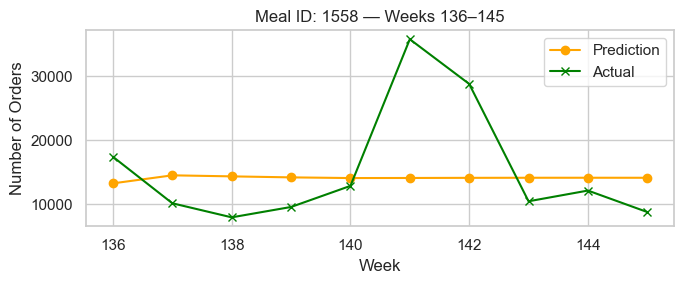

Validation MAE: 6812.42, RMSE: 9115.54


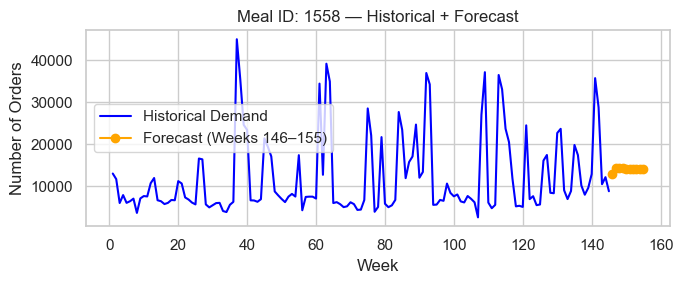

Predictions for Weeks 146–155: [12809.17952272 14364.77077022 14317.24269328 14257.159289
 14085.99461827 14105.19688359 14120.12240741 14131.2525765
 14137.47640085 14133.87360084]


In [125]:
# Same pipeline for next meal
meal_id = selected_meals[4]
meal_df = df[df['meal_id'] == meal_id].groupby('week')['num_orders'].sum().reset_index()
all_weeks = pd.DataFrame({'week': range(1, 146)})
meal_df = pd.merge(all_weeks, meal_df, on='week', how='left').fillna(method='ffill')
train_df = meal_df[meal_df['week'] <= 135]
X, y, scaler = prepare_sequences(train_df['num_orders'], sequence_length=10)
val_actual = meal_df[meal_df['week'] > 135]['num_orders'].values

model = SimpleRNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
epochs = 10
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        mae = mean_absolute_error(y.numpy(), outputs.numpy())
        rmse = mean_squared_error(y.numpy(), outputs.numpy(), squared=False)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}, MAE: {mae:.2f}, RMSE: {rmse:.2f}")

model.eval()
input_seq = X[-1].unsqueeze(0)  
val_predictions = []
with torch.no_grad():
    for _ in range(10):  
        pred = model(input_seq)
        val_predictions.append(pred.item())
        input_seq = torch.cat((input_seq[:, 1:, :], pred.view(1, 1, 1)), dim=1)
val_forecast = scaler.inverse_transform(np.array(val_predictions).reshape(-1, 1)).flatten()

weeks = np.arange(136, 146)
plt.figure(figsize=(7, 3))
plt.plot(weeks, val_forecast, label='Prediction', marker='o', color='orange')
plt.plot(weeks, val_actual, label='Actual', marker='x', color='green')
plt.title(f'Meal ID: {meal_id} — Weeks 136–145')
plt.xlabel('Week')
plt.ylabel('Number of Orders')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

mae = mean_absolute_error(val_actual, val_forecast)
rmse = mean_squared_error(val_actual, val_forecast, squared=False)
print(f"Validation MAE: {mae:.2f}, RMSE: {rmse:.2f}")

test_predictions = []
input_seq = torch.tensor(scaler.transform(meal_df['num_orders'].values[-10:].reshape(-1, 1)), dtype=torch.float32).unsqueeze(0)
with torch.no_grad():
    for _ in range(10):
        pred = model(input_seq)
        test_predictions.append(pred.item())
        input_seq = torch.cat((input_seq[:, 1:, :], pred.view(1, 1, 1)), dim=1)
test_forecast = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1)).flatten()
historical_weeks = meal_df['week'].values
historical_orders = meal_df['num_orders'].values
forecast_weeks = np.arange(146, 156)

plt.figure(figsize=(7, 3))
plt.plot(historical_weeks, historical_orders, label='Historical Demand', color='blue')
plt.plot(forecast_weeks, test_forecast, label='Forecast (Weeks 146–155)', marker='o', color='orange')
plt.title(f'Meal ID: {meal_id} — Historical + Forecast')
plt.xlabel('Week')
plt.ylabel('Number of Orders')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

test_predictions = []
input_seq = torch.tensor(scaler.transform(meal_df['num_orders'].values[-10:].reshape(-1, 1)), dtype=torch.float32).unsqueeze(0)
with torch.no_grad():
    for _ in range(10):
        pred = model(input_seq)
        test_predictions.append(pred.item())
        input_seq = torch.cat((input_seq[:, 1:, :], pred.view(1, 1, 1)), dim=1)
test_forecast = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1)).flatten()
print(f"Predictions for Weeks 146–155: {test_forecast}")

Not a lot to say here, this model stood no chance. We can probably cut it some slack though because this historical data is soooo volatile, making it difficult to predict. I wonder why these RNNs have such little MAE and RAE during the training phase, but are struggling during validation and producing much higher MAE then? Maybe if I add more epochs it will be able to learn better and yield better results? We'll try that on the next meal.

## Meal 2704

Epoch [1/20], Loss: 0.403407, MAE: 0.60, RMSE: 0.64
Epoch [2/20], Loss: 0.130555, MAE: 0.30, RMSE: 0.36
Epoch [3/20], Loss: 0.057474, MAE: 0.17, RMSE: 0.24
Epoch [4/20], Loss: 0.043842, MAE: 0.18, RMSE: 0.21
Epoch [5/20], Loss: 0.059850, MAE: 0.21, RMSE: 0.24
Epoch [6/20], Loss: 0.059177, MAE: 0.21, RMSE: 0.24
Epoch [7/20], Loss: 0.047284, MAE: 0.19, RMSE: 0.22
Epoch [8/20], Loss: 0.040897, MAE: 0.17, RMSE: 0.20
Epoch [9/20], Loss: 0.042174, MAE: 0.16, RMSE: 0.21
Epoch [10/20], Loss: 0.046068, MAE: 0.16, RMSE: 0.21
Epoch [11/20], Loss: 0.048046, MAE: 0.16, RMSE: 0.22
Epoch [12/20], Loss: 0.046786, MAE: 0.16, RMSE: 0.22
Epoch [13/20], Loss: 0.043393, MAE: 0.15, RMSE: 0.21
Epoch [14/20], Loss: 0.039805, MAE: 0.15, RMSE: 0.20
Epoch [15/20], Loss: 0.037649, MAE: 0.15, RMSE: 0.19
Epoch [16/20], Loss: 0.037527, MAE: 0.16, RMSE: 0.19
Epoch [17/20], Loss: 0.038720, MAE: 0.16, RMSE: 0.20
Epoch [18/20], Loss: 0.039670, MAE: 0.17, RMSE: 0.20
Epoch [19/20], Loss: 0.039246, MAE: 0.17, RMSE: 0.20
Ep

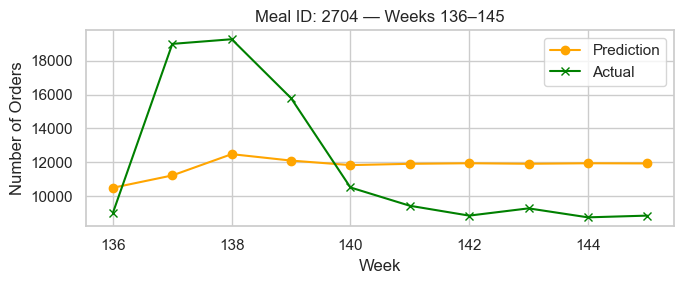

Validation MAE: 3554.97, RMSE: 4081.30


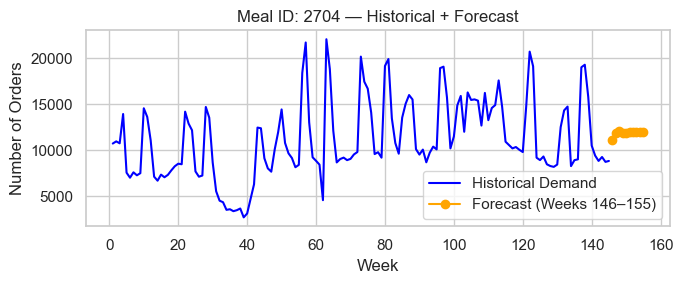

Predictions for Weeks 146–155: [11098.70209616 11863.6338836  12118.57816368 11869.81462991
 11851.31150961 11945.40221196 11952.51490253 11949.9261685
 11950.31735498 11944.13085592]


In [130]:
# Same pipeline for next meal
meal_id = selected_meals[5]
meal_df = df[df['meal_id'] == meal_id].groupby('week')['num_orders'].sum().reset_index()
all_weeks = pd.DataFrame({'week': range(1, 146)})
meal_df = pd.merge(all_weeks, meal_df, on='week', how='left').fillna(method='ffill')
train_df = meal_df[meal_df['week'] <= 135]
X, y, scaler = prepare_sequences(train_df['num_orders'], sequence_length=10)
val_actual = meal_df[meal_df['week'] > 135]['num_orders'].values

model = SimpleRNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
epochs = 20
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        mae = mean_absolute_error(y.numpy(), outputs.numpy())
        rmse = mean_squared_error(y.numpy(), outputs.numpy(), squared=False)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}, MAE: {mae:.2f}, RMSE: {rmse:.2f}")

model.eval()
input_seq = X[-1].unsqueeze(0)  
val_predictions = []
with torch.no_grad():
    for _ in range(10):  
        pred = model(input_seq)
        val_predictions.append(pred.item())
        input_seq = torch.cat((input_seq[:, 1:, :], pred.view(1, 1, 1)), dim=1)
val_forecast = scaler.inverse_transform(np.array(val_predictions).reshape(-1, 1)).flatten()

weeks = np.arange(136, 146)
plt.figure(figsize=(7, 3))
plt.plot(weeks, val_forecast, label='Prediction', marker='o', color='orange')
plt.plot(weeks, val_actual, label='Actual', marker='x', color='green')
plt.title(f'Meal ID: {meal_id} — Weeks 136–145')
plt.xlabel('Week')
plt.ylabel('Number of Orders')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

mae = mean_absolute_error(val_actual, val_forecast)
rmse = mean_squared_error(val_actual, val_forecast, squared=False)
print(f"Validation MAE: {mae:.2f}, RMSE: {rmse:.2f}")

test_predictions = []
input_seq = torch.tensor(scaler.transform(meal_df['num_orders'].values[-10:].reshape(-1, 1)), dtype=torch.float32).unsqueeze(0)
with torch.no_grad():
    for _ in range(10):
        pred = model(input_seq)
        test_predictions.append(pred.item())
        input_seq = torch.cat((input_seq[:, 1:, :], pred.view(1, 1, 1)), dim=1)
test_forecast = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1)).flatten()
historical_weeks = meal_df['week'].values
historical_orders = meal_df['num_orders'].values
forecast_weeks = np.arange(146, 156)

plt.figure(figsize=(7, 3))
plt.plot(historical_weeks, historical_orders, label='Historical Demand', color='blue')
plt.plot(forecast_weeks, test_forecast, label='Forecast (Weeks 146–155)', marker='o', color='orange')
plt.title(f'Meal ID: {meal_id} — Historical + Forecast')
plt.xlabel('Week')
plt.ylabel('Number of Orders')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

test_predictions = []
input_seq = torch.tensor(scaler.transform(meal_df['num_orders'].values[-10:].reshape(-1, 1)), dtype=torch.float32).unsqueeze(0)
with torch.no_grad():
    for _ in range(10):
        pred = model(input_seq)
        test_predictions.append(pred.item())
        input_seq = torch.cat((input_seq[:, 1:, :], pred.view(1, 1, 1)), dim=1)
test_forecast = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1)).flatten()
print(f"Predictions for Weeks 146–155: {test_forecast}")

Increasing the number of epochs did not seem to do much in terms of getting better performance during the validation testing. However, that does makes sense because the network is converging to some solution with a low MAE, but seems completely blown away by testing data. This RNN predicted the last ten weeks of the training data to be more steady, when it clearly was not truthfully like that. Onto the next meal. 

## Meal 2126

Epoch [1/10], Loss: 0.028873, MAE: 0.12, RMSE: 0.17
Epoch [2/10], Loss: 0.113926, MAE: 0.31, RMSE: 0.34
Epoch [3/10], Loss: 0.030472, MAE: 0.13, RMSE: 0.17
Epoch [4/10], Loss: 0.032714, MAE: 0.14, RMSE: 0.18
Epoch [5/10], Loss: 0.042779, MAE: 0.16, RMSE: 0.21
Epoch [6/10], Loss: 0.044429, MAE: 0.17, RMSE: 0.21
Epoch [7/10], Loss: 0.039919, MAE: 0.16, RMSE: 0.20
Epoch [8/10], Loss: 0.033388, MAE: 0.14, RMSE: 0.18
Epoch [9/10], Loss: 0.028003, MAE: 0.12, RMSE: 0.17
Epoch [10/10], Loss: 0.026009, MAE: 0.12, RMSE: 0.16


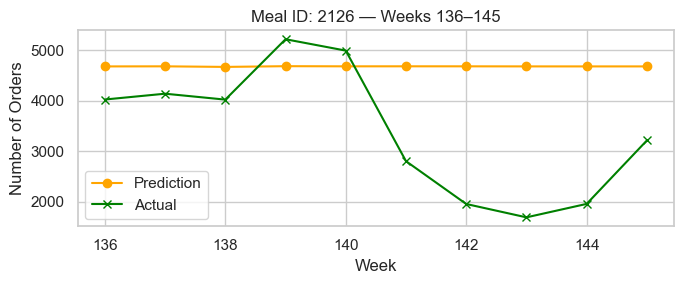

Validation MAE: 1445.15, RMSE: 1757.63


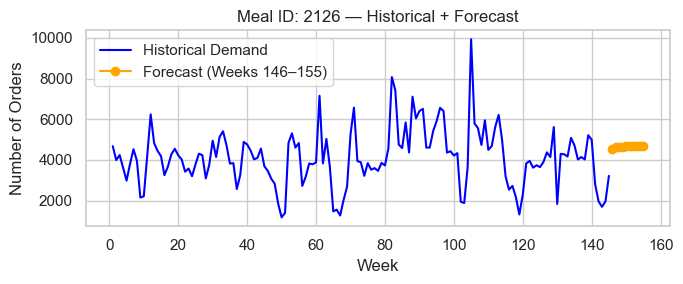

Predictions for Weeks 146–155: [4562.10248733 4619.3106578  4643.63978308 4655.58658987 4672.17258853
 4678.86453402 4683.93036026 4684.1914584  4681.76481223 4680.33817196]


In [133]:
# Same pipeline for next meal
meal_id = selected_meals[6]
meal_df = df[df['meal_id'] == meal_id].groupby('week')['num_orders'].sum().reset_index()
all_weeks = pd.DataFrame({'week': range(1, 146)})
meal_df = pd.merge(all_weeks, meal_df, on='week', how='left').fillna(method='ffill')
train_df = meal_df[meal_df['week'] <= 135]
X, y, scaler = prepare_sequences(train_df['num_orders'], sequence_length=10)
val_actual = meal_df[meal_df['week'] > 135]['num_orders'].values

model = SimpleRNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
epochs = 10
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        mae = mean_absolute_error(y.numpy(), outputs.numpy())
        rmse = mean_squared_error(y.numpy(), outputs.numpy(), squared=False)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}, MAE: {mae:.2f}, RMSE: {rmse:.2f}")

model.eval()
input_seq = X[-1].unsqueeze(0)  
val_predictions = []
with torch.no_grad():
    for _ in range(10):  
        pred = model(input_seq)
        val_predictions.append(pred.item())
        input_seq = torch.cat((input_seq[:, 1:, :], pred.view(1, 1, 1)), dim=1)
val_forecast = scaler.inverse_transform(np.array(val_predictions).reshape(-1, 1)).flatten()

weeks = np.arange(136, 146)
plt.figure(figsize=(7, 3))
plt.plot(weeks, val_forecast, label='Prediction', marker='o', color='orange')
plt.plot(weeks, val_actual, label='Actual', marker='x', color='green')
plt.title(f'Meal ID: {meal_id} — Weeks 136–145')
plt.xlabel('Week')
plt.ylabel('Number of Orders')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

mae = mean_absolute_error(val_actual, val_forecast)
rmse = mean_squared_error(val_actual, val_forecast, squared=False)
print(f"Validation MAE: {mae:.2f}, RMSE: {rmse:.2f}")

test_predictions = []
input_seq = torch.tensor(scaler.transform(meal_df['num_orders'].values[-10:].reshape(-1, 1)), dtype=torch.float32).unsqueeze(0)
with torch.no_grad():
    for _ in range(10):
        pred = model(input_seq)
        test_predictions.append(pred.item())
        input_seq = torch.cat((input_seq[:, 1:, :], pred.view(1, 1, 1)), dim=1)
test_forecast = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1)).flatten()
historical_weeks = meal_df['week'].values
historical_orders = meal_df['num_orders'].values
forecast_weeks = np.arange(146, 156)

plt.figure(figsize=(7, 3))
plt.plot(historical_weeks, historical_orders, label='Historical Demand', color='blue')
plt.plot(forecast_weeks, test_forecast, label='Forecast (Weeks 146–155)', marker='o', color='orange')
plt.title(f'Meal ID: {meal_id} — Historical + Forecast')
plt.xlabel('Week')
plt.ylabel('Number of Orders')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

test_predictions = []
input_seq = torch.tensor(scaler.transform(meal_df['num_orders'].values[-10:].reshape(-1, 1)), dtype=torch.float32).unsqueeze(0)
with torch.no_grad():
    for _ in range(10):
        pred = model(input_seq)
        test_predictions.append(pred.item())
        input_seq = torch.cat((input_seq[:, 1:, :], pred.view(1, 1, 1)), dim=1)
test_forecast = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1)).flatten()
print(f"Predictions for Weeks 146–155: {test_forecast}")

## Meal 2304

Epoch [1/10], Loss: 0.070300, MAE: 0.22, RMSE: 0.27
Epoch [2/10], Loss: 0.025116, MAE: 0.13, RMSE: 0.16
Epoch [3/10], Loss: 0.034627, MAE: 0.16, RMSE: 0.19
Epoch [4/10], Loss: 0.022336, MAE: 0.11, RMSE: 0.15
Epoch [5/10], Loss: 0.020532, MAE: 0.09, RMSE: 0.14
Epoch [6/10], Loss: 0.023855, MAE: 0.10, RMSE: 0.15
Epoch [7/10], Loss: 0.023791, MAE: 0.10, RMSE: 0.15
Epoch [8/10], Loss: 0.021181, MAE: 0.09, RMSE: 0.15
Epoch [9/10], Loss: 0.018969, MAE: 0.08, RMSE: 0.14
Epoch [10/10], Loss: 0.018388, MAE: 0.09, RMSE: 0.14


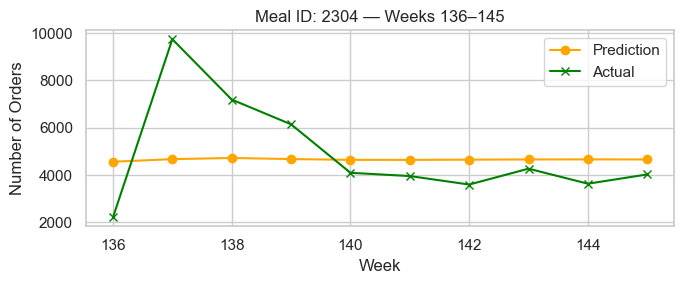

Validation MAE: 1569.45, RMSE: 2073.03


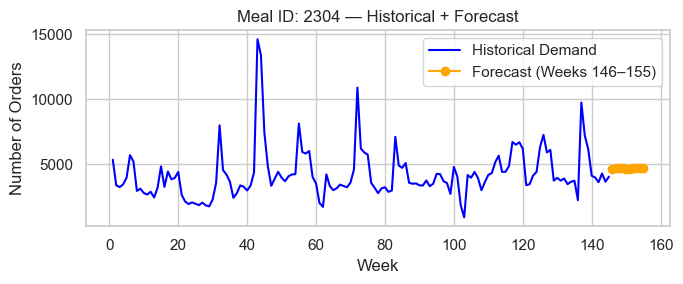

Predictions for Weeks 146–155: [4596.33166027 4666.05834031 4697.61299014 4666.14921927 4648.06921792
 4648.22559524 4655.30719519 4660.31290674 4661.51275468 4659.73693061]


In [141]:
# Same pipeline for next meal
meal_id = selected_meals[7]
meal_df = df[df['meal_id'] == meal_id].groupby('week')['num_orders'].sum().reset_index()
all_weeks = pd.DataFrame({'week': range(1, 146)})
meal_df = pd.merge(all_weeks, meal_df, on='week', how='left').fillna(method='ffill')
train_df = meal_df[meal_df['week'] <= 135]
X, y, scaler = prepare_sequences(train_df['num_orders'], sequence_length=10)
val_actual = meal_df[meal_df['week'] > 135]['num_orders'].values

model = SimpleRNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
epochs = 10
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        mae = mean_absolute_error(y.numpy(), outputs.numpy())
        rmse = mean_squared_error(y.numpy(), outputs.numpy(), squared=False)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}, MAE: {mae:.2f}, RMSE: {rmse:.2f}")

model.eval()
input_seq = X[-1].unsqueeze(0)  
val_predictions = []
with torch.no_grad():
    for _ in range(10):  
        pred = model(input_seq)
        val_predictions.append(pred.item())
        input_seq = torch.cat((input_seq[:, 1:, :], pred.view(1, 1, 1)), dim=1)
val_forecast = scaler.inverse_transform(np.array(val_predictions).reshape(-1, 1)).flatten()

weeks = np.arange(136, 146)
plt.figure(figsize=(7, 3))
plt.plot(weeks, val_forecast, label='Prediction', marker='o', color='orange')
plt.plot(weeks, val_actual, label='Actual', marker='x', color='green')
plt.title(f'Meal ID: {meal_id} — Weeks 136–145')
plt.xlabel('Week')
plt.ylabel('Number of Orders')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

mae = mean_absolute_error(val_actual, val_forecast)
rmse = mean_squared_error(val_actual, val_forecast, squared=False)
print(f"Validation MAE: {mae:.2f}, RMSE: {rmse:.2f}")

test_predictions = []
input_seq = torch.tensor(scaler.transform(meal_df['num_orders'].values[-10:].reshape(-1, 1)), dtype=torch.float32).unsqueeze(0)
with torch.no_grad():
    for _ in range(10):
        pred = model(input_seq)
        test_predictions.append(pred.item())
        input_seq = torch.cat((input_seq[:, 1:, :], pred.view(1, 1, 1)), dim=1)
test_forecast = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1)).flatten()
historical_weeks = meal_df['week'].values
historical_orders = meal_df['num_orders'].values
forecast_weeks = np.arange(146, 156)

plt.figure(figsize=(7, 3))
plt.plot(historical_weeks, historical_orders, label='Historical Demand', color='blue')
plt.plot(forecast_weeks, test_forecast, label='Forecast (Weeks 146–155)', marker='o', color='orange')
plt.title(f'Meal ID: {meal_id} — Historical + Forecast')
plt.xlabel('Week')
plt.ylabel('Number of Orders')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

test_predictions = []
input_seq = torch.tensor(scaler.transform(meal_df['num_orders'].values[-10:].reshape(-1, 1)), dtype=torch.float32).unsqueeze(0)
with torch.no_grad():
    for _ in range(10):
        pred = model(input_seq)
        test_predictions.append(pred.item())
        input_seq = torch.cat((input_seq[:, 1:, :], pred.view(1, 1, 1)), dim=1)
test_forecast = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1)).flatten()
print(f"Predictions for Weeks 146–155: {test_forecast}")

Past week 140, this RNN actually does a pretty good job of aligning with the historical truth data. It was not able to predict the spike around week 137, but a fairly solid result. It is predicting the next 10 weeks will remain steady around 4600 orders per week. Onto the next meal. 

## Meal 2139

Epoch [1/10], Loss: 0.334138, MAE: 0.54, RMSE: 0.58
Epoch [2/10], Loss: 0.115999, MAE: 0.29, RMSE: 0.34
Epoch [3/10], Loss: 0.041082, MAE: 0.16, RMSE: 0.20
Epoch [4/10], Loss: 0.102471, MAE: 0.27, RMSE: 0.32
Epoch [5/10], Loss: 0.059867, MAE: 0.20, RMSE: 0.24
Epoch [6/10], Loss: 0.039234, MAE: 0.16, RMSE: 0.20
Epoch [7/10], Loss: 0.050532, MAE: 0.18, RMSE: 0.22
Epoch [8/10], Loss: 0.061237, MAE: 0.20, RMSE: 0.25
Epoch [9/10], Loss: 0.058605, MAE: 0.20, RMSE: 0.24
Epoch [10/10], Loss: 0.047985, MAE: 0.17, RMSE: 0.22


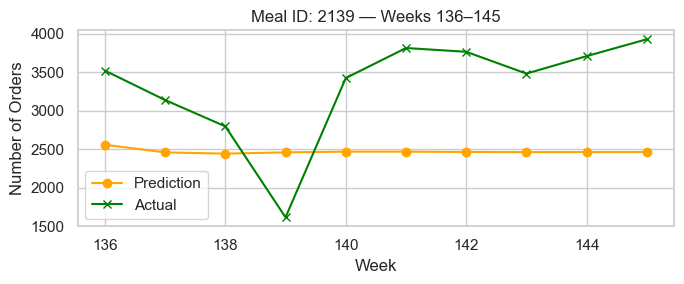

Validation MAE: 1017.08, RMSE: 1066.53


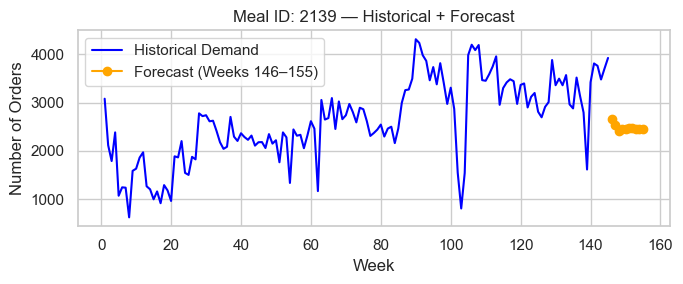

Predictions for Weeks 146–155: [2670.28061843 2532.55100799 2417.87855065 2446.50213027 2463.5353514
 2472.14026117 2467.21233976 2461.88346839 2461.02633333 2462.16844654]


In [145]:
# Same pipeline for next meal
meal_id = selected_meals[8]
meal_df = df[df['meal_id'] == meal_id].groupby('week')['num_orders'].sum().reset_index()
all_weeks = pd.DataFrame({'week': range(1, 146)})
meal_df = pd.merge(all_weeks, meal_df, on='week', how='left').fillna(method='ffill')
train_df = meal_df[meal_df['week'] <= 135]
X, y, scaler = prepare_sequences(train_df['num_orders'], sequence_length=10)
val_actual = meal_df[meal_df['week'] > 135]['num_orders'].values

model = SimpleRNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
epochs = 10
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        mae = mean_absolute_error(y.numpy(), outputs.numpy())
        rmse = mean_squared_error(y.numpy(), outputs.numpy(), squared=False)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}, MAE: {mae:.2f}, RMSE: {rmse:.2f}")

model.eval()
input_seq = X[-1].unsqueeze(0)  
val_predictions = []
with torch.no_grad():
    for _ in range(10):  
        pred = model(input_seq)
        val_predictions.append(pred.item())
        input_seq = torch.cat((input_seq[:, 1:, :], pred.view(1, 1, 1)), dim=1)
val_forecast = scaler.inverse_transform(np.array(val_predictions).reshape(-1, 1)).flatten()

weeks = np.arange(136, 146)
plt.figure(figsize=(7, 3))
plt.plot(weeks, val_forecast, label='Prediction', marker='o', color='orange')
plt.plot(weeks, val_actual, label='Actual', marker='x', color='green')
plt.title(f'Meal ID: {meal_id} — Weeks 136–145')
plt.xlabel('Week')
plt.ylabel('Number of Orders')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

mae = mean_absolute_error(val_actual, val_forecast)
rmse = mean_squared_error(val_actual, val_forecast, squared=False)
print(f"Validation MAE: {mae:.2f}, RMSE: {rmse:.2f}")

test_predictions = []
input_seq = torch.tensor(scaler.transform(meal_df['num_orders'].values[-10:].reshape(-1, 1)), dtype=torch.float32).unsqueeze(0)
with torch.no_grad():
    for _ in range(10):
        pred = model(input_seq)
        test_predictions.append(pred.item())
        input_seq = torch.cat((input_seq[:, 1:, :], pred.view(1, 1, 1)), dim=1)
test_forecast = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1)).flatten()
historical_weeks = meal_df['week'].values
historical_orders = meal_df['num_orders'].values
forecast_weeks = np.arange(146, 156)

plt.figure(figsize=(7, 3))
plt.plot(historical_weeks, historical_orders, label='Historical Demand', color='blue')
plt.plot(forecast_weeks, test_forecast, label='Forecast (Weeks 146–155)', marker='o', color='orange')
plt.title(f'Meal ID: {meal_id} — Historical + Forecast')
plt.xlabel('Week')
plt.ylabel('Number of Orders')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

test_predictions = []
input_seq = torch.tensor(scaler.transform(meal_df['num_orders'].values[-10:].reshape(-1, 1)), dtype=torch.float32).unsqueeze(0)
with torch.no_grad():
    for _ in range(10):
        pred = model(input_seq)
        test_predictions.append(pred.item())
        input_seq = torch.cat((input_seq[:, 1:, :], pred.view(1, 1, 1)), dim=1)
test_forecast = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1)).flatten()
print(f"Predictions for Weeks 146–155: {test_forecast}")

The model's predictions for the last 10 weeks of historical data is pretty bad all the way around. MAE of about 1017 when the average demand is around 3000 orders. Also, the RNN is forecasting a sharp drop starting at week 146. If this was a stock price, we should sell now and re-buy around week 150 (if we had faith in our model, which I do not). Last meal!

## Meal 1525

Epoch [1/10], Loss: 0.196336, MAE: 0.40, RMSE: 0.44
Epoch [2/10], Loss: 0.074908, MAE: 0.22, RMSE: 0.27
Epoch [3/10], Loss: 0.043580, MAE: 0.18, RMSE: 0.21
Epoch [4/10], Loss: 0.062881, MAE: 0.22, RMSE: 0.25
Epoch [5/10], Loss: 0.043487, MAE: 0.18, RMSE: 0.21
Epoch [6/10], Loss: 0.038056, MAE: 0.15, RMSE: 0.20
Epoch [7/10], Loss: 0.041483, MAE: 0.15, RMSE: 0.20
Epoch [8/10], Loss: 0.044231, MAE: 0.15, RMSE: 0.21
Epoch [9/10], Loss: 0.043290, MAE: 0.15, RMSE: 0.21
Epoch [10/10], Loss: 0.039710, MAE: 0.14, RMSE: 0.20


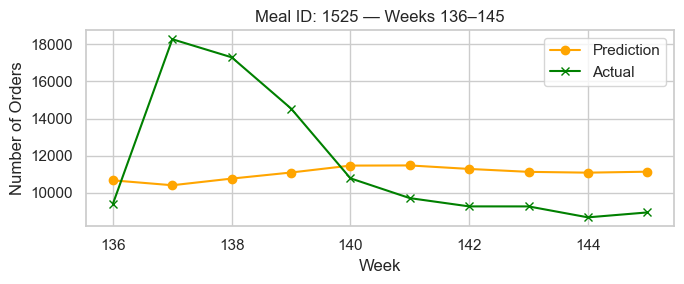

Validation MAE: 2998.88, RMSE: 3732.94


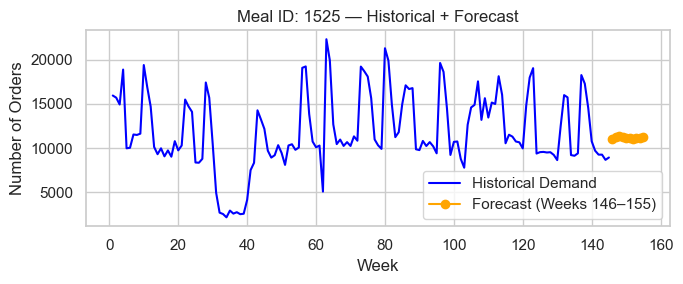

Predictions for Weeks 146–155: [11009.32501185 11279.4451074  11378.19915515 11291.66188654
 11203.79825905 11101.76160803 11093.19156596 11147.39291283
 11206.22541782 11227.84188822]


In [149]:
# Same pipeline for next meal
meal_id = selected_meals[9]
meal_df = df[df['meal_id'] == meal_id].groupby('week')['num_orders'].sum().reset_index()
all_weeks = pd.DataFrame({'week': range(1, 146)})
meal_df = pd.merge(all_weeks, meal_df, on='week', how='left').fillna(method='ffill')
train_df = meal_df[meal_df['week'] <= 135]
X, y, scaler = prepare_sequences(train_df['num_orders'], sequence_length=10)
val_actual = meal_df[meal_df['week'] > 135]['num_orders'].values

model = SimpleRNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
epochs = 10
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        mae = mean_absolute_error(y.numpy(), outputs.numpy())
        rmse = mean_squared_error(y.numpy(), outputs.numpy(), squared=False)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}, MAE: {mae:.2f}, RMSE: {rmse:.2f}")

model.eval()
input_seq = X[-1].unsqueeze(0)  
val_predictions = []
with torch.no_grad():
    for _ in range(10):  
        pred = model(input_seq)
        val_predictions.append(pred.item())
        input_seq = torch.cat((input_seq[:, 1:, :], pred.view(1, 1, 1)), dim=1)
val_forecast = scaler.inverse_transform(np.array(val_predictions).reshape(-1, 1)).flatten()

weeks = np.arange(136, 146)
plt.figure(figsize=(7, 3))
plt.plot(weeks, val_forecast, label='Prediction', marker='o', color='orange')
plt.plot(weeks, val_actual, label='Actual', marker='x', color='green')
plt.title(f'Meal ID: {meal_id} — Weeks 136–145')
plt.xlabel('Week')
plt.ylabel('Number of Orders')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

mae = mean_absolute_error(val_actual, val_forecast)
rmse = mean_squared_error(val_actual, val_forecast, squared=False)
print(f"Validation MAE: {mae:.2f}, RMSE: {rmse:.2f}")

test_predictions = []
input_seq = torch.tensor(scaler.transform(meal_df['num_orders'].values[-10:].reshape(-1, 1)), dtype=torch.float32).unsqueeze(0)
with torch.no_grad():
    for _ in range(10):
        pred = model(input_seq)
        test_predictions.append(pred.item())
        input_seq = torch.cat((input_seq[:, 1:, :], pred.view(1, 1, 1)), dim=1)
test_forecast = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1)).flatten()
historical_weeks = meal_df['week'].values
historical_orders = meal_df['num_orders'].values
forecast_weeks = np.arange(146, 156)

plt.figure(figsize=(7, 3))
plt.plot(historical_weeks, historical_orders, label='Historical Demand', color='blue')
plt.plot(forecast_weeks, test_forecast, label='Forecast (Weeks 146–155)', marker='o', color='orange')
plt.title(f'Meal ID: {meal_id} — Historical + Forecast')
plt.xlabel('Week')
plt.ylabel('Number of Orders')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

test_predictions = []
input_seq = torch.tensor(scaler.transform(meal_df['num_orders'].values[-10:].reshape(-1, 1)), dtype=torch.float32).unsqueeze(0)
with torch.no_grad():
    for _ in range(10):
        pred = model(input_seq)
        test_predictions.append(pred.item())
        input_seq = torch.cat((input_seq[:, 1:, :], pred.view(1, 1, 1)), dim=1)
test_forecast = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1)).flatten()
print(f"Predictions for Weeks 146–155: {test_forecast}")

All of these meals have seemed very hard to predict the demand of. All of them seem so volatile with very short stints of steady behavior. The RNN for this meal is forecasting a slight increase in demand for weeks 146-155. 